<a href="https://colab.research.google.com/github/Blaze10/DL/blob/main/regularization/regular_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

## Create the data

In [4]:
# create data
n_per_clust = 200
th = np.linspace(0,4*np.pi, n_per_clust)
r1 = 10
r2 = 15

a = [r1 * np.cos(th) + np.random.randn(n_per_clust) * 3,
     r1 * np.sin(th) + np.random.randn(n_per_clust)]

b = [r2 * np.cos(th) + np.random.randn(n_per_clust) * 3,
     r2 * np.sin(th) + np.random.randn(n_per_clust)]

labels_np = np.vstack((np.zeros((n_per_clust, 1)), np.ones((n_per_clust, 1))))

# concatenate into matrix
data_np = np.hstack((a,b)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

print(data[:5], labels[:5])

tensor([[12.4481, -0.0709],
        [ 7.0283,  2.2809],
        [-0.5615,  1.8352],
        [13.5467,  2.3140],
        [14.9211,  3.1007]]) tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])


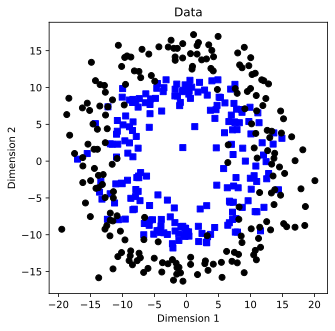

In [6]:
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs')
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko')
plt.title('Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

## Separate the data into DataLoaders

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size = len(test_data))

## Creating the model

In [8]:
class TheModelClass(nn.Module):
  def __init__(self, dropout_rate):
    super(TheModelClass, self).__init__()

    # layers
    self.input = nn.Linear(2,128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)

    self.dr = dropout_rate

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.dropout(x, p=self.dr, training=self.training)
    x = F.relu(self.hidden(x))
    x = F.dropout(x, p=self.dr, training=self.training)
    x = self.output(x)
    return x

In [9]:
tmpnet = TheModelClass(.25)
tmpdata = torch.randn((10,2))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.1186],
        [ 0.0349],
        [ 0.0285],
        [ 0.1334],
        [ 0.0260],
        [ 0.2197],
        [ 0.0348],
        [-0.0095],
        [ 0.1586],
        [ 0.0031]], grad_fn=<AddmmBackward0>)

## Functions to create and train the net

In [11]:
def createANewModel(dropout_rate):
  ANNQC = TheModelClass(dropout_rate)
  loss_fun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(ANNQC.parameters(), lr=.002)
  return ANNQC, loss_fun, optimizer

In [23]:
num_epochs = 1000
def train_model(ANNQC, loss_fun, optimizer):
  train_acc = []
  test_acc = []

  for epochi in range(num_epochs):
    ANNQC.train()

    batch_acc = []
    for X,y in train_loader:
      yHat = ANNQC(X)
      loss = loss_fun(yHat, y)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_acc.append(100 * torch.mean(((yHat>0)==y).float()).item())
    
    train_acc.append(np.mean(batch_acc))

    ANNQC.eval()
    X,y = next(iter(test_loader))
    yHat = ANNQC(X)
    test_acc.append(100 * torch.mean(((yHat>0)==y).float()).item())
  
  return train_acc, test_acc


## Test the model

In [24]:
dropout_rate = .0
ANNQC, loss_fun, optimizer = createANewModel(dropout_rate)
train_acc, test_acc = train_model(ANNQC, loss_fun, optimizer)

In [36]:
## create a 1D smoothing factor
def smooth(x, k=5):
  return np.convolve(x, np.ones(k)/k, mode='same')

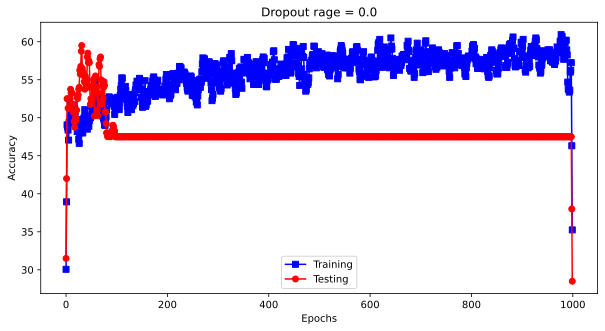

In [37]:
plt.figure(figsize=(10,5))
plt.plot(smooth(train_acc), 'bs-')
plt.plot(smooth(test_acc), 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Dropout rage = {dropout_rate}')
plt.legend(['Training', 'Testing'])
plt.show()

## Experiment

In [26]:
dropout_rates = np.arange(10)/10
results = np.zeros((len(dropout_rates), 2))

for di in range(len(dropout_rates)):
  ANNQC, loss_fun, optimizer = createANewModel(dropout_rates[di])
  train_acc, test_acc = train_model(ANNQC, loss_fun, optimizer)

  results[di, 0] = np.mean(train_acc[-100:])
  results[di, 1] = np.mean(test_acc[-100:])

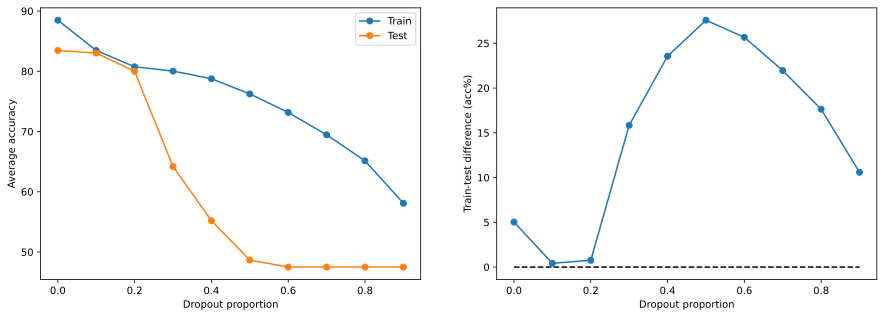

In [27]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropout_rates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropout_rates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

In [39]:
class TheModelClass(nn.Module):
  def __init__(self, dropout_rate):
    super(TheModelClass, self).__init__()

    # layers
    self.input = nn.Linear(2,256)
    self.hidden = nn.Linear(256, 256)
    self.output = nn.Linear(256, 1)

    self.dr = dropout_rate

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.dropout(x, p=self.dr, training=self.training)
    x = F.relu(self.hidden(x))
    x = F.dropout(x, p=self.dr, training=self.training)
    x = self.output(x)
    return x

In [40]:
dropout_rates = np.arange(10)/10
results = np.zeros((len(dropout_rates), 2))

for di in range(len(dropout_rates)):
  ANNQC, loss_fun, optimizer = createANewModel(dropout_rates[di])
  train_acc, test_acc = train_model(ANNQC, loss_fun, optimizer)

  results[di, 0] = np.mean(train_acc[-100:])
  results[di, 1] = np.mean(test_acc[-100:])

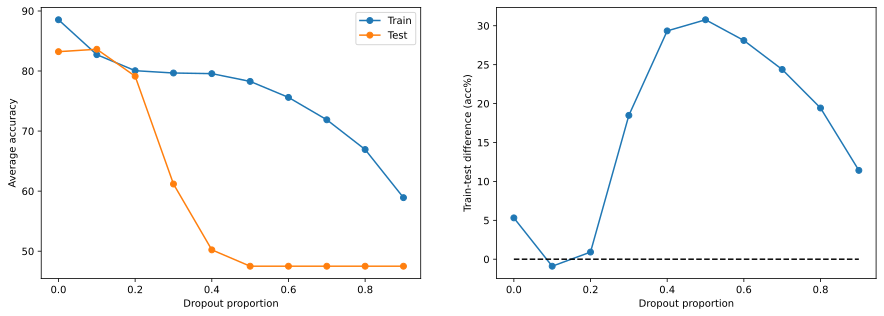

In [41]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropout_rates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropout_rates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

In [42]:
class TheModelClass(nn.Module):
  def __init__(self, dropout_rate):
    super(TheModelClass, self).__init__()

    # layers
    self.input = nn.Linear(2,64)
    self.hidden = nn.Linear(64, 64)
    self.output = nn.Linear(64, 1)

    self.dr = dropout_rate

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.dropout(x, p=self.dr, training=self.training)
    x = F.relu(self.hidden(x))
    x = F.dropout(x, p=self.dr, training=self.training)
    x = self.output(x)
    return x

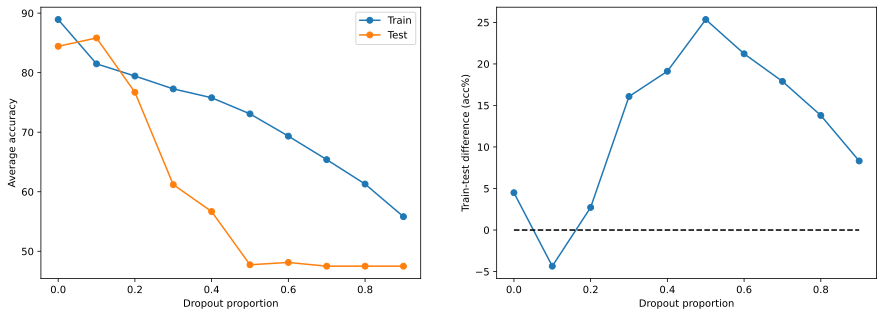

In [43]:
dropout_rates = np.arange(10)/10
results = np.zeros((len(dropout_rates), 2))

for di in range(len(dropout_rates)):
  ANNQC, loss_fun, optimizer = createANewModel(dropout_rates[di])
  train_acc, test_acc = train_model(ANNQC, loss_fun, optimizer)

  results[di, 0] = np.mean(train_acc[-100:])
  results[di, 1] = np.mean(test_acc[-100:])


fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropout_rates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropout_rates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()